This notebook provides an example of remvoing biases + finetuning. The reusults are also compared with the results of the homogeneous normalization.

In [1]:
import sys
sys.path.append("..")

In [11]:
import torch
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.weight_matching import weight_matching
from source.utils.activation_matching import activation_matching
from source.utils.connect import eval_line, calculate_models_distance
from source.utils.logger import Logger
from torch.utils.data import DataLoader
from source.utils.train import train
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from copy import deepcopy

In [3]:
class config:
    model = 'cifar_vgg16'
    dataset = 'cifar10'
    special_init = 'vgg_init' # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [4]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
model_1, model_2 = load_model(config).to(device), load_model(config).to(device)

sd_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_1_160.pt', map_location=device)
sd_2 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_2_160.pt', map_location=device)

model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)

<All keys matched successfully>

Matching

In [ ]:
sd_2_wm, _ = weight_matching(config.model, sd_1, sd_2, device=device)
sd_2_am, _ = activation_matching(config.model, model_1, model_2, trainloader_noaug, 100, device) # no obvious difference found between trainloader and trainloader_noaug

In [20]:
model_2_wm = load_model(config).to(device)
model_2_wm.load_state_dict(sd_2_wm)
model_2_am = load_model(config).to(device)
model_2_am.load_state_dict(sd_2_am)

<All keys matched successfully>

Remove bias

In [7]:
sd_1_nobias = OrderedDict([(k, v) for k, v in sd_1.items() if 'bias' not in k])
sd_2_nobias = OrderedDict([(k, v) for k, v in sd_2.items() if 'bias' not in k])

config.model = 'cifar_vgg16_nobias'
model_1_nobias = load_model(config).to(device)
model_2_nobias = load_model(config).to(device) 
model_1_nobias.load_state_dict(sd_1_nobias)
model_2_nobias.load_state_dict(sd_2_nobias)

<All keys matched successfully>

In [ ]:
sd_2_nobias_wm, perm_2_nobias_wm = weight_matching('cifar_vgg16_nobias', model_1_nobias.state_dict(),
                                   model_2_nobias.state_dict(), device=device, return_perm=True)

sd_2_nobias_am, perm_2_nobias_am = activation_matching('cifar_vgg16_nobias', model_1_nobias,
                                       model_2_nobias, trainloader, print_freq=100, device=device, return_perm=True)

In [9]:
config.model = 'cifar_vgg16_nobias'
model_2_nobias_wm = load_model(config).to(device)
model_2_nobias_wm.load_state_dict(sd_2_nobias_wm)
model_2_nobias_am = load_model(config).to(device)
model_2_nobias_am.load_state_dict(sd_2_nobias_am)

<All keys matched successfully>

Fine-tuning

In [16]:
model_1_nobias_ft = deepcopy(model_1_nobias)
model_2_nobias_ft = deepcopy(model_2_nobias)
model_1_nobias_ft.load_state_dict(sd_1_nobias)
model_2_nobias_ft.load_state_dict(sd_2_nobias)

optimizer_1_nobias = torch.optim.SGD(model_1_nobias_ft.parameters(), lr=1e-2, momentum=0.9)
optimizer_2_nobias = torch.optim.SGD(model_2_nobias_ft.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
loss_s = [[], []]
top1_s = [[], []]
distance_s = [[], []]
for epoch in range(10):
    loss_1, top1, _, _ = train(trainloader, model_1_nobias_ft, criterion, optimizer_1_nobias, epoch, device, config)
    distance = calculate_models_distance(model_1_nobias.state_dict(), sd_1_nobias)
    loss_s[0].append(loss_1)
    top1_s[0].append(top1)
    distance_s[0].append(distance)
    
    loss_2, top2, _, _ = train(trainloader, model_2_nobias_ft, criterion, optimizer_2_nobias, epoch, device, config)
    distance = calculate_models_distance(model_2_nobias.state_dict(), sd_2_nobias)
    loss_s[1].append(loss_1)    
    top1_s[1].append(top1)
    distance_s[1].append(distance)

In [ ]:
sd_2_nobias_ft_wm, _ = weight_matching('cifar_vgg16_nobias', model_1_nobias_ft.state_dict(),
                                   model_2_nobias_ft.state_dict(), device=device)

sd_2_nobias_ft_am, _ = activation_matching('cifar_vgg16_nobias', model_1_nobias_ft,
                                       model_2_nobias_ft, trainloader, print_freq=100, device=device)

In [21]:
config.model = 'cifar_vgg16_nobias'
model_2_nobias_ft_wm = load_model(config).to(device)
model_2_nobias_ft_wm.load_state_dict(sd_2_nobias_ft_wm)
model_2_nobias_ft_am = load_model(config).to(device)
model_2_nobias_ft_am.load_state_dict(sd_2_nobias_ft_am)

<All keys matched successfully>

In [ ]:
lmc_nobias_wm = eval_line(model_1_nobias, model_2_nobias_wm, testloader, criterion, device, config, n=config.n)
lmc_nobias_am = eval_line(model_1_nobias, model_2_nobias_am, testloader, criterion, device, config, n=config.n)

lmc_bias_wm = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n)
lmc_bias_am = eval_line(model_1, model_2_am, testloader, criterion, device, config, n=config.n)

lmc_nobias_ft_wm = eval_line(model_1_nobias_ft, model_2_nobias_ft_wm, testloader, criterion, device, config, n=config.n)
lmc_nobias_ft_am = eval_line(model_1_nobias_ft, model_2_nobias_ft_am, testloader, criterion, device, config, n=config.n)

Homogeneous normalization

In [ ]:
lmc_bias_wm_norm = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n, bias_norm=True)
lmc_bias_am_norm = eval_line(model_1, model_2_am, testloader, criterion, device, config, n=config.n, bias_norm=True)

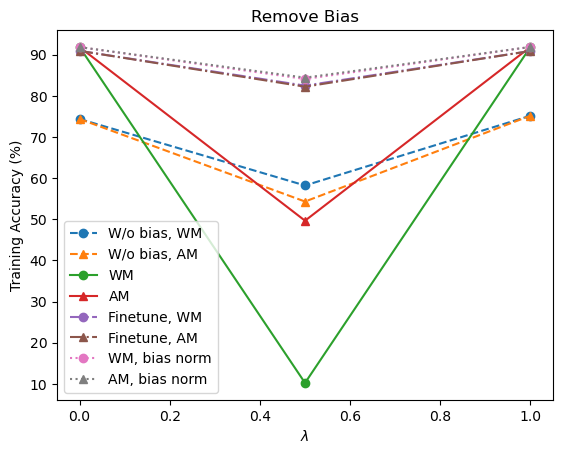

In [25]:
x_axis = np.linspace(0, 1, config.n)

plt.plot(x_axis, lmc_nobias_wm[:, 1], label='W/o bias, WM', marker='o', linestyle='--')
plt.plot(x_axis, lmc_nobias_am[:, 1], label='W/o bias, AM', marker='^', linestyle='--')
plt.plot(x_axis, lmc_bias_wm[:, 1], label='WM', marker='o')
plt.plot(x_axis, lmc_bias_am[:, 1], label='AM', marker='^')
plt.plot(x_axis, lmc_nobias_ft_wm[:, 1], label='Finetune, WM', marker='o', linestyle='-.')
plt.plot(x_axis, lmc_nobias_ft_am[:, 1], label='Finetune, AM', marker='^', linestyle='-.')
plt.plot(x_axis, lmc_bias_wm_norm[:, 1], label='WM, bias norm', marker='o', linestyle=':')
plt.plot(x_axis, lmc_bias_am_norm[:, 1], label='AM, bias norm', marker='^', linestyle=':')

plt.title('Remove Bias')
plt.ylabel('Training Accuracy (%)')
plt.xlabel(r'$\lambda$')
plt.legend()